<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/DeepPit_Voxelmorph_ROI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
from pathlib import Path 

ROOT = "/content/drive"    
drive.mount(ROOT)

# Useful paths
PROJ_PATH            = Path(ROOT)/"My Drive/PitProj/"

Mounted at /content/drive


# Voxelmorph ROI

Align an unlabelled MR to a labelled MR/CT (via pre-trained voxelmoprh) in order to generate ROI for the unlabelled MR.

Sources: 

- MR Atlas and labels: from https://github.com/voxelmorph/voxelmorph/tree/master/data/

- Voxelmorph Tutorial: https://colab.research.google.com/drive/1WiqyF7dCdnNBIANEY80Pxw_mVz4fyV-S?usp=sharing#scrollTo=UCw0avYgPXMd

- Kaggle https://www.kaggle.com/kmader/voxelmorph-on-ct-data#Load-Atlas-Data

- Kaggle https://www.kaggle.com/kmader/voxelmorph-demo

# Imports

In [3]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph 

# imports
import os, sys

# third party imports
import numpy as np
import nibabel as nib

import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm # deep-learning based registration library
import neurite as ne # medical image analysis with tensorflow

     |████████████████████████████████| 81kB 5.0MB/s 
     |████████████████████████████████| 92kB 5.6MB/s 


# Fixed image

atlas shape (160, 192, 224), num labels = 30


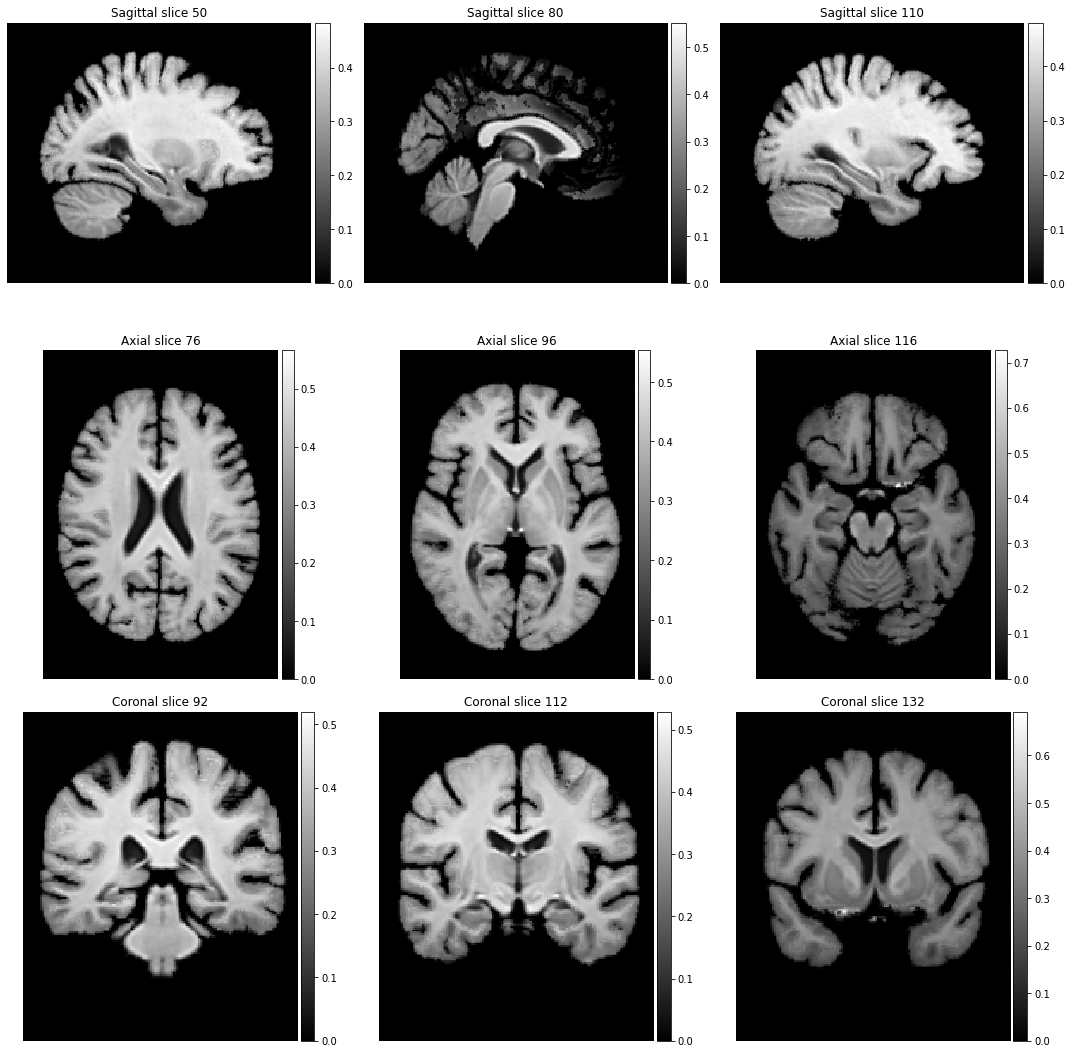

(<Figure size 1080x1080 with 18 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaf0f95490>,
       dtype=object))

In [8]:
# MR atlas from https://github.com/voxelmorph/voxelmorph/tree/master/data/

atlas  =  np.load(f"{PROJ_PATH}/atlas.npz")
labels =  np.load(f"{PROJ_PATH}/labels.npz")

atlas_vol = atlas["vol"]
atlas_seg = atlas["seg"]

labels = labels["labels"]

atlas_vol_shape = atlas_vol.shape # include slices?

print(f"atlas shape {atlas_vol.shape}, num labels = {len(labels)}")


In [ ]:
# viz middle slices in each axis (sagittal, coronal, axial)

slices = []
titles = []

# sagittal slices
ax      = 0
mid_idx = atlas_vol.shape[ax]//2
idxs    = (mid_idx - 30, mid_idx, mid_idx + 30)
titles += [f"Sagittal slice {i}" for i in idxs]
slices += [np.take(atlas_vol, i, axis=ax) for i in idxs]

# axial slices (rotated 90, k = 1)
ax      = 1
mid_idx = atlas_vol.shape[ax]//2
idxs    = (mid_idx - 20, mid_idx, mid_idx + 20)
titles += [f"Axial slice {i}" for i in idxs]
slices += [np.rot90(np.take(atlas_vol, i, axis=ax), 1) for i in idxs]

# coronal slices (rotated 90, k = -1)
ax      = 2
mid_idx = atlas_vol.shape[ax]//2
idxs    = (mid_idx - 20, mid_idx, mid_idx + 20)
titles += [f"Coronal slice {i}" for i in idxs]
slices += [np.rot90(np.take(atlas_vol, i, axis=ax), -1) for i in idxs]

ne.plot.slices(slices, cmaps=['gray'], do_colorbars=True, grid=[3,3], titles=titles)

# atlas_mid_slices = [np.take(atlas_vol, atlas_vol.shape[d]//2, axis=d) for d in range(3)]
# atlas_mid_slices[1] = np.rot90(atlas_mid_slices[1], 1)  # coronal
# atlas_mid_slices[2] = np.rot90(atlas_mid_slices[2], -1) # axial
# ne.plot.slices(atlas_mid_slices, cmaps=['gray'], do_colorbars=True, grid=[1,3])

# Moving image

In [12]:
# import

# choose a nii file
nii_folder = f"{PROJ_PATH}/play"
nii_file = f"{nii_folder}/ABIDE_50454_MRI_MP-RAGE_br_raw_20120830175600888_S164683_I328693 (1).nii"

# get the underlying MR in RAS+ = canonical coords
nii_vol    = nib.load(nii_file)
moving_vol = nii_vol.get_fdata(dtype=np.float32)

print("Fixed image coord system (original): ", nib.aff2axcodes(nii_vol.affine))
print(f"Voxel cut sizes: {nii_vol.header['pixdim'][1:4]}")
print(f"Fixed image shape: {moving_vol.shape}")


Fixed image coord system (original):  ('L', 'A', 'S')
Voxel cut sizes: [1.2 0.5 0.5]
Fixed image shape: (160, 480, 512)


TypeError: ignored

In [14]:
print(nii_vol)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (160, 480, 512)
affine: 
[[-1.19953215e+00  0.00000000e+00  1.39608476e-02  9.18019867e+01]
 [ 0.00000000e+00  5.00000000e-01  0.00000000e+00 -7.93669434e+01]
 [ 3.35060358e-02  0.00000000e+00  4.99805063e-01 -1.37258316e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'50454'
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 160 480 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.   1.2  0.5  0.5  1.   1.   1.   1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 

In [15]:
# https://www.brainvoyager.com/bv/doc/UsersGuide/CoordsAndTransforms/ProcessingNIfTIFiles.html
# - the transformation matrix maps voxel coordinates to scanner world coordinates.
print(nii_vol.header["qform_code"], nii_vol.header["sform_code"])

1 1


In [ ]:
import mne

ras_mni_t = mne.transforms.read_ras_mni_t('sample', subjects_dir)  # from FS
mni_affine = np.dot(ras_mni_t['trans'], img.affine)  # vox->ras->MNI
img_mni = nibabel.Nifti1Image(img.dataobj, mni_affine)  # now in MNI coords!

In [ ]:

# re-orient
aligned_moving_vol = np.array()
moving_vol[0] = np.rot90(moving_vol[0], 1) # rotate sagittal by 90
moving_vol = moving_vol[:, [0, 2, 1]] # switch coronal and axial

# viz middle slices in each axis (sagittal, coronal, axial)

slices = []
titles = []

# sagittal slices (rotated 90)
ax      = 0
mid_idx = moving_vol.shape[ax]//2
idxs    = (mid_idx - 30, mid_idx, mid_idx + 30)
titles += [f"Sagittal slice {i}" for i in idxs]
slices += [np.take(moving_vol, i, axis=ax) for i in idxs]

# axial slices (rotated 90, k = 1)
ax      = 1
mid_idx = moving_vol.shape[ax]//2
idxs    = (mid_idx - 20, mid_idx, mid_idx + 20)
titles += [f"Axial slice {i}" for i in idxs]
slices += [np.rot90(np.take(moving_vol, i, axis=ax), 1) for i in idxs]

# coronal slices (rotated 90, k = -1)
ax      = 2
mid_idx = moving_vol.shape[ax]//2
idxs    = (mid_idx - 20, mid_idx, mid_idx + 20)
titles += [f"Coronal slice {i}" for i in idxs]
slices += [np.rot90(np.take(moving_vol, i, axis=ax), -1) for i in idxs]

ne.plot.slices(slices, cmaps=['gray'], do_colorbars=True, grid=[3,3], titles=titles)

# Convert to RAS+ = canonical coords
# np_arr = nib.as_closest_canonical(nii_arr).get_fdata(dtype=np.float32)
# print("MR shape: ", np_arr.shape, " (axial, sagittal, coronal)")

In [ ]:
np_arr = nib.as_closest_canonical(nii_arr).get_fdata(dtype=np.float32)


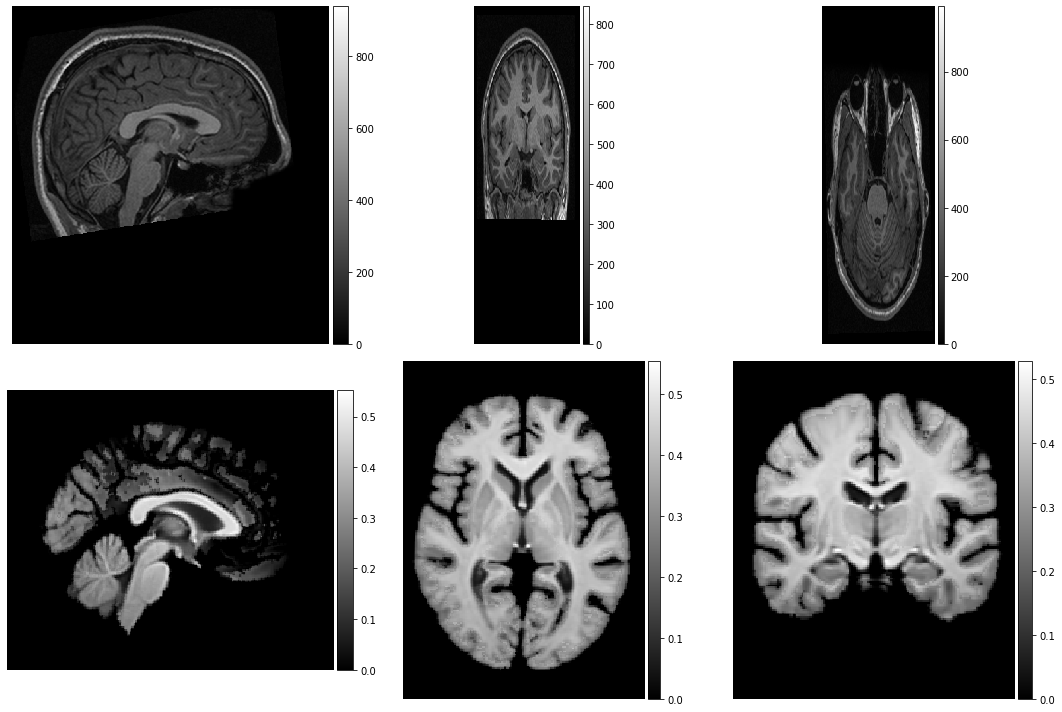

In [ ]:
nii_mid_slices_fixed = [np.take(np_arr, np_arr.shape[d]//2, axis=d) for d in range(3)]
nii_mid_slices_fixed[0] = np.rot90(nii_mid_slices_fixed[0], 1) # sagittal
nii_mid_slices_fixed[1] = np.rot90(nii_mid_slices_fixed[1], 1) # coronal
nii_mid_slices_fixed[2] = np.rot90(nii_mid_slices_fixed[2], 1) # axial

slices = (atlas_vol.shape[0]//2, atlas_vol.shape[1]//2, )
atlas_mid_slices_fixed = [np.take(atlas_vol, atlas_vol.shape[d]//2, axis=d) for d in range(3)]
atlas_mid_slices_fixed[1] = np.rot90(atlas_mid_slices_fixed[1], 1)
atlas_mid_slices_fixed[2] = np.rot90(atlas_mid_slices_fixed[2], -1)

ne.plot.slices(nii_mid_slices_fixed + atlas_mid_slices_fixed, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

# Data

1. Load moving image, fixed image (= CT scan or MR atlas).
2. Match orientation
2. Resize to same slice thickness (voxel resolution) and spacing between voxels
3. Intensity normalize to have same distribution between moving and fixed image
4. Affinely align (is this necessary as pre-processing step?)

## Fixed image

In [4]:
# import

# choose a nii file
nii_folder = f"{PROJ_PATH}/play"
nii_file = f"{nii_folder}/ABIDE_50454_MRI_MP-RAGE_br_raw_20120830175600888_S164683_I328693 (1).nii"

# get the underlying MR in RAS+ = canonical coords
nii_vol    = nib.load(nii_file)
nii_np_arr = nii_vol.get_fdata(dtype=np.float32)

print("NifTi coord system (original): ", nib.aff2axcodes(nii_arr.affine))
print(f"Nii shape: {nii_np_arr.shape}")
print(f"Voxel cut sizes: {nii_vol.header['pixdim'][1:4]}")

# Convert to RAS+ = canonical coords
# np_arr = nib.as_closest_canonical(nii_arr).get_fdata(dtype=np.float32)
# print("MR shape: ", np_arr.shape, " (axial, sagittal, coronal)")

NameError: ignored

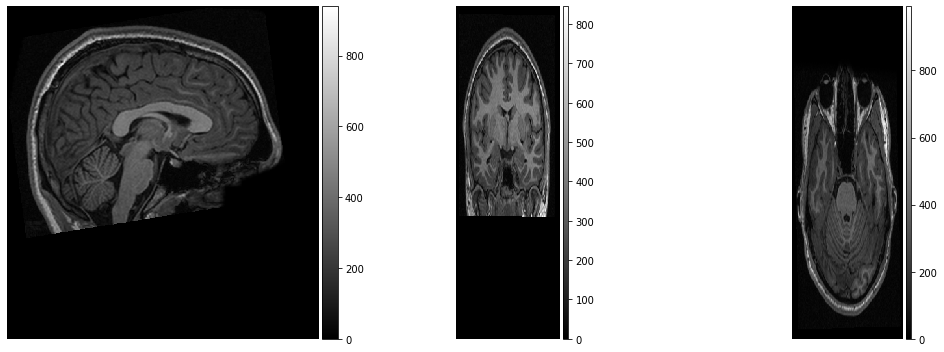

In [ ]:
# quickly viz mid slice

nii_mid_slices = [np.take(np_arr, np_arr.shape[d]//2, axis=d) for d in range(3)]
nii_mid_slices[0] = np.rot90(nii_mid_slices[0], 1) # sagittal
nii_mid_slices[1] = np.rot90(nii_mid_slices[1], 1) # coronal
nii_mid_slices[2] = np.rot90(nii_mid_slices[2], 1) # axial

ne.plot.slices(nii_mid_slices, cmaps=['gray'], do_colorbars=True, grid=[1,3]);

In [ ]:
ne.plot.slices

Nifti input has 512 axial slices.


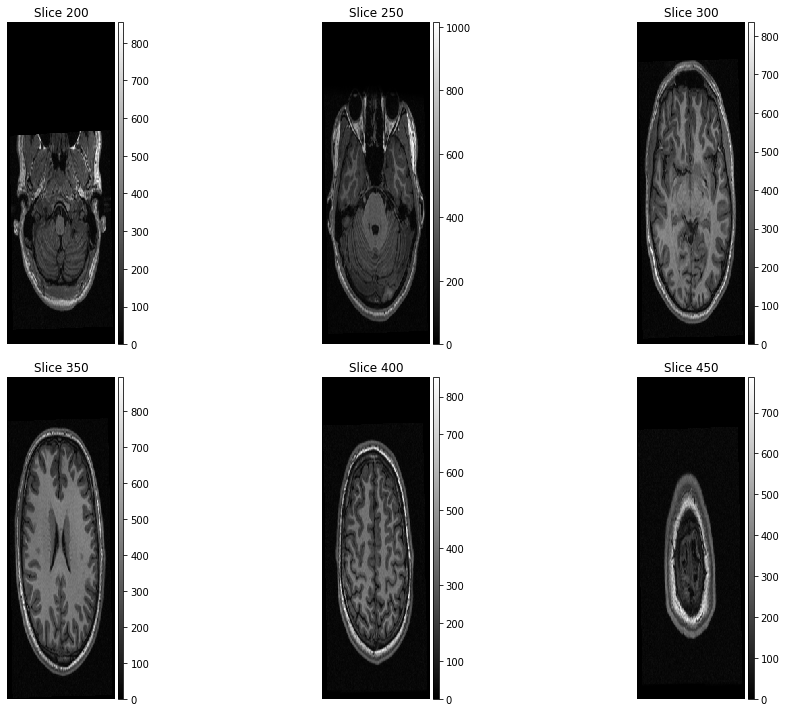

In [ ]:
# viz axial
print(f"Nifti input has {nii_np_arr.shape[2]} axial slices.")

axial_slice_idxs = (200,250,300,350, 400, 450)
titles = [f"Slice {idx}" for idx in axial_slice_idxs]

axial_slices = [np.rot90(np.take(nii_np_arr, idx, axis=2), 1) for idx in axial_slice_idxs]
ne.plot.slices(axial_slices, cmaps=['gray'], do_colorbars=True, grid=[2,3], titles = titles);

## MR atlas

In [ ]:
# MR atlas from https://github.com/voxelmorph/voxelmorph/tree/master/data/

atlas  =  np.load(f"{PROJ_PATH}/atlas.npz")
labels =  np.load(f"{PROJ_PATH}/labels.npz")

atlas_vol = atlas["vol"]
atlas_seg = atlas["seg"]

labels = labels["labels"]

atlas_vol_shape = atlas_vol.shape # include slices?

print(f"atlas shape {atlas_vol.shape}, num labels = {len(labels)}")

atlas shape (160, 192, 224), num labels = 30


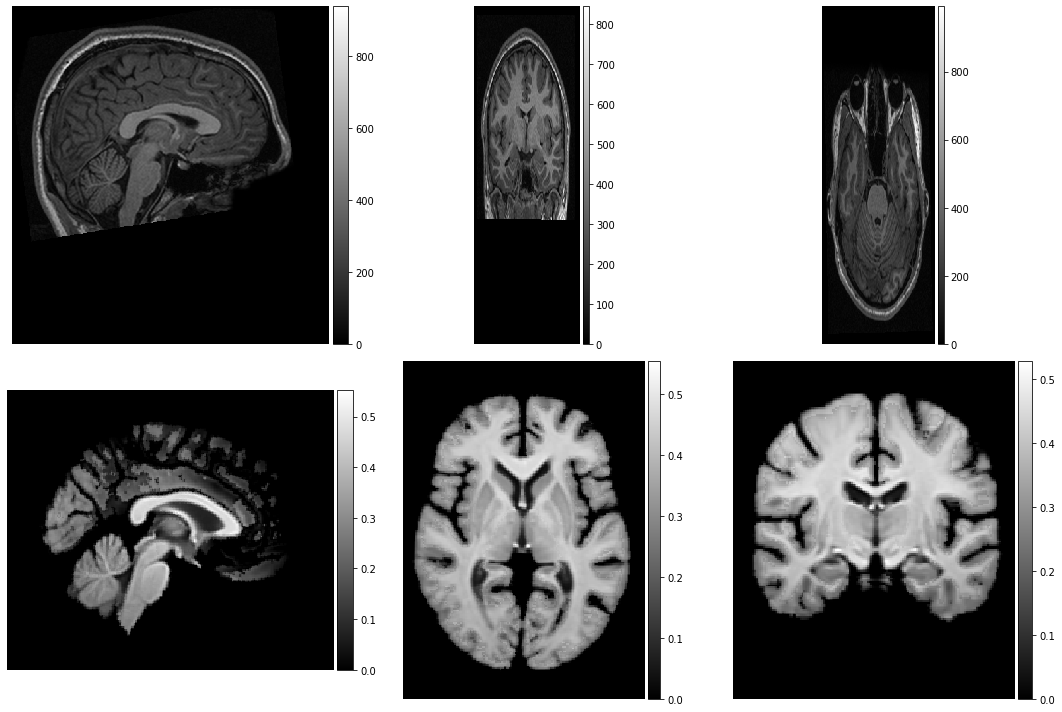

In [ ]:
nii_mid_slices_fixed = [np.take(np_arr, np_arr.shape[d]//2, axis=d) for d in range(3)]
nii_mid_slices_fixed[0] = np.rot90(nii_mid_slices_fixed[0], 1) # sagittal
nii_mid_slices_fixed[1] = np.rot90(nii_mid_slices_fixed[1], 1) # coronal
nii_mid_slices_fixed[2] = np.rot90(nii_mid_slices_fixed[2], 1) # axial

slices = (atlas_vol.shape[0]//2, atlas_vol.shape[1]//2, )
atlas_mid_slices_fixed = [np.take(atlas_vol, atlas_vol.shape[d]//2, axis=d) for d in range(3)]
atlas_mid_slices_fixed[1] = np.rot90(atlas_mid_slices_fixed[1], 1)
atlas_mid_slices_fixed[2] = np.rot90(atlas_mid_slices_fixed[2], -1)

ne.plot.slices(nii_mid_slices_fixed + atlas_mid_slices_fixed, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

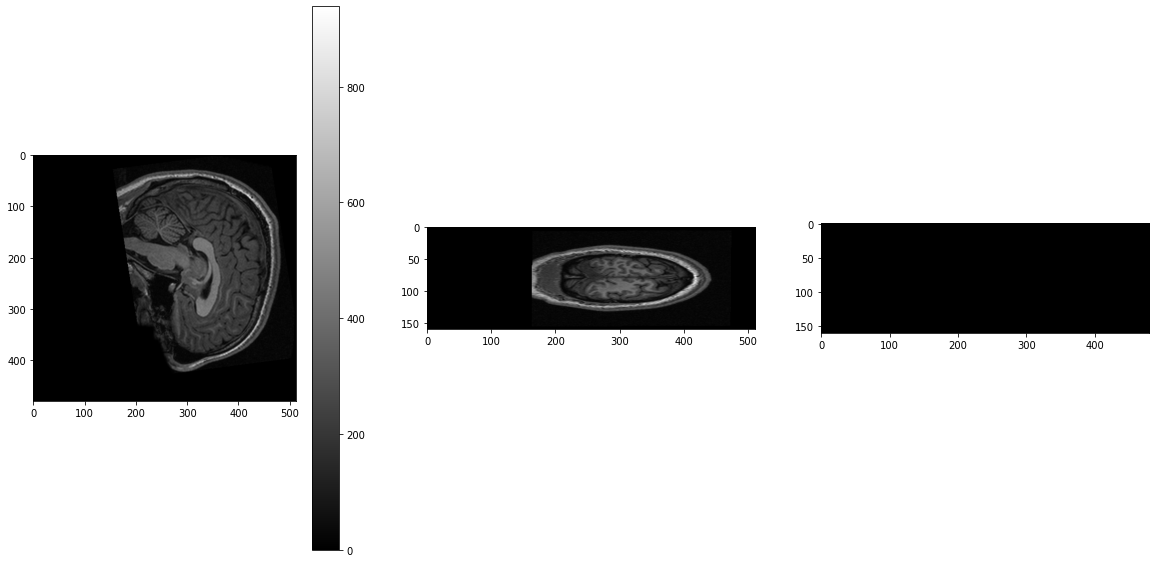

In [ ]:
import matplotlib.pyplot as plt

idx = 80

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
im1 = ax1.imshow(np_arr[idx], cmap='gray')
im2 = ax2.imshow(np_arr[:,idx,:], cmap='gray')
im3 = ax3.imshow(np_arr[:,:,idx], cmap='gray')

fig.colorbar(im1, ax=ax1)

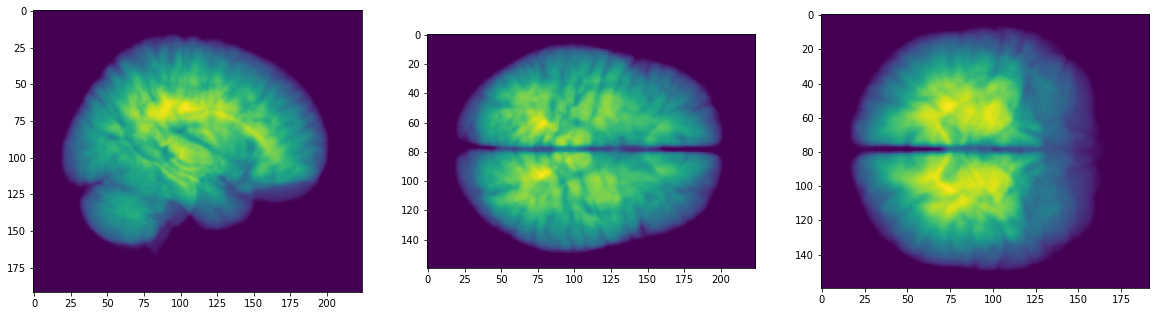

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol, 0))
ax2.imshow(np.mean(atlas_vol, 1))
ax3.imshow(np.mean(atlas_vol, 2))

In [ ]:
nii_arr.shape

(160, 480, 512)

### Atlas stats

Source: https://www.kaggle.com/kmader/voxelmorph-on-ct-data#Load-Atlas-Data

In [ ]:
# atlas has many 0 values, remove this mass in calc
def get_stats(vol, include_zero=True): 
  if include_zero: return vol.min(), vol.max(), vol.mean(), vol.std()
  return vol.min(), vol.max(), vol[vol>0].mean(), vol[vol>0].std()

def print_stats(min, max, mean, std): print(f"min: {min:.2f}, max: {max:.2f}, mean = {mean:.2f}, std = {std:.2f}")

min: 0.00, max: 0.73, mean = 0.29, std = 0.12


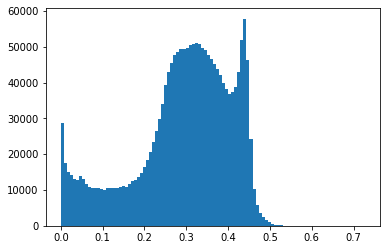

In [ ]:
atlas_min, atlas_max, atlas_mean, atlas_std = get_stats(atlas_vol, include_zero=False)
print_stats(atlas_min, atlas_max, atlas_mean, atlas_std)

plt.hist(atlas_vol[atlas_vol>0], 100);

## viz atlas

Source: https://www.kaggle.com/kmader/voxelmorph-demo

In [ ]:
import matplotlib.pyplot as plt

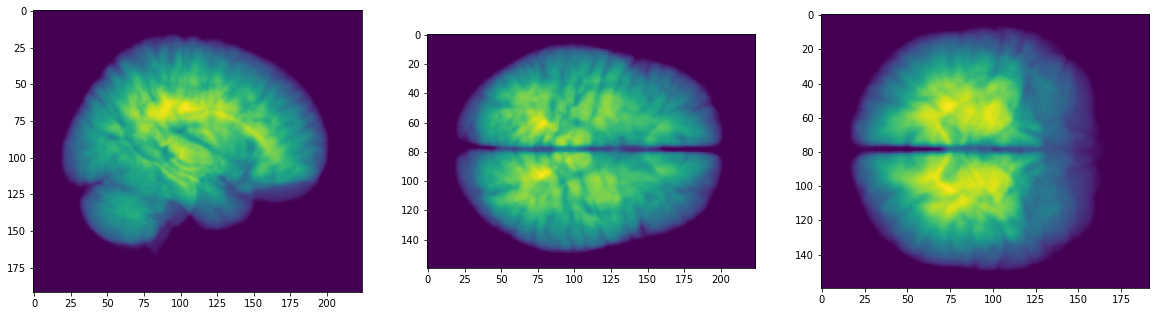

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol, 0))
ax2.imshow(np.mean(atlas_vol, 1))
ax3.imshow(np.mean(atlas_vol, 2))

NameError: ignored

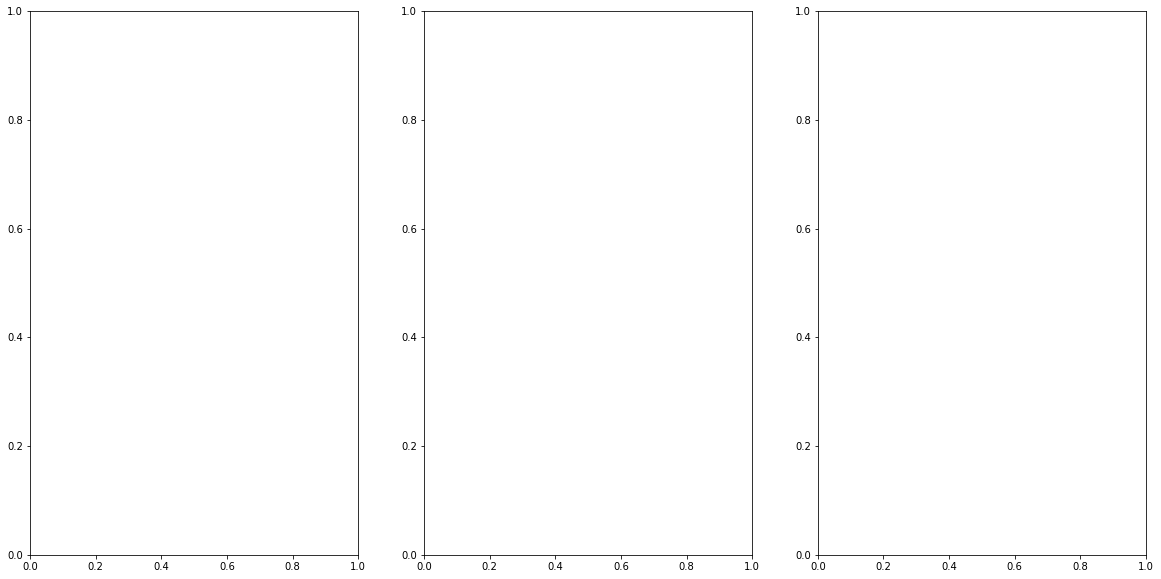

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol, 0))
ax2.imshow(np.mean(atlas_vol, 1))
ax3.imshow(np.mean(atlas_vol, 2))

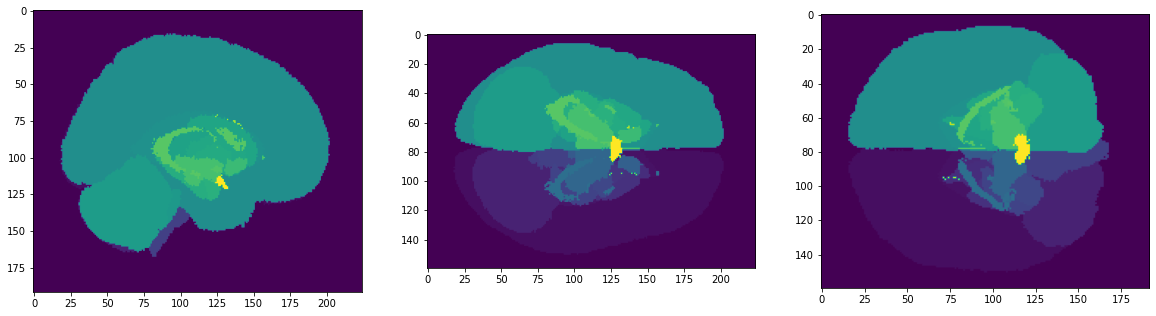

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(atlas_seg, 0))
ax2.imshow(np.max(atlas_seg, 1))
ax3.imshow(np.max(atlas_seg, 2))

In [ ]:
print(atlas_vol.shape, atlas_vol.min(), atlas_vol[atlas_vol>0].mean(), atlas_vol[atlas_vol>0].std(), atlas_vol.max())
plt.hist(atlas_vol[atlas_vol>0], 100);

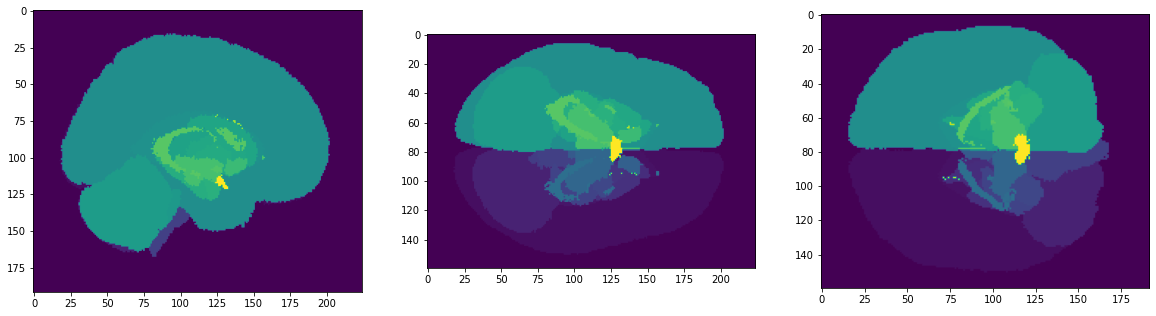

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(vxm_atlas_seg, 0))
ax2.imshow(np.max(vxm_atlas_seg, 1))
ax3.imshow(np.max(vxm_atlas_seg, 2))

## Moving image

In [ ]:
# get binary mask associated w/ ROI
moving_mr  =  np.load(f"{PROJ_PATH}/dicom_img_numpy_array.npy")
manual_roi =  np.load(f"{PROJ_PATH}/binary_segmentation_mask.npy")

print(f"moving mr shape: {moving_mr.shape}. manual roi: {manual_roi.shape}")

moving mr shape: (160, 480, 512). manual roi: (160, 480, 512)


min: 0.00, max: 1140.00, mean = 151.65, std = 148.42


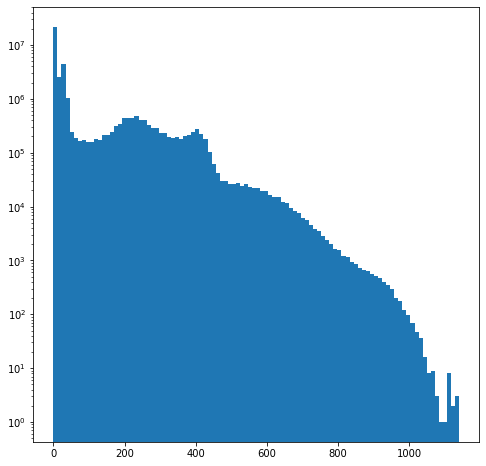

In [ ]:
moving_mr_min, moving_mr_max, moving_mr_mean, moving_mr_std = get_stats(moving_mr, include_zero=False)
print_stats(moving_mr_min, moving_mr_max, moving_mr_mean, moving_mr_std)

fig, ax1 = plt.subplots(1,1,figsize = (8, 8))
ax1.hist(moving_mr.ravel(), 100, log = True);

# viz

In [ ]:
sag = np.swapaxes(moving_mr,0,1)

In [ ]:
sag.shape

(480, 160, 512)

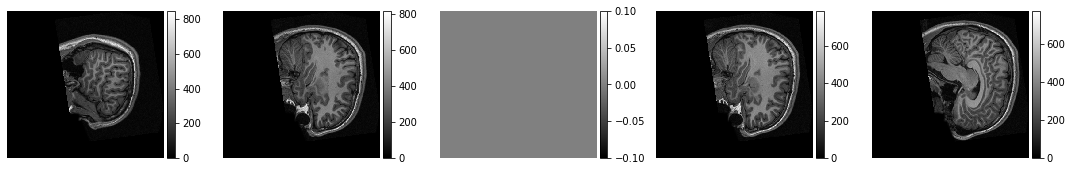

In [ ]:
# extract some brains
nb_vis = 5
x_train = moving_mr

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

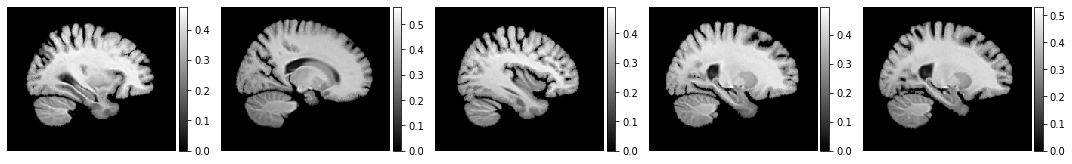

In [ ]:
# extract some brains
nb_vis = 5
x_train = atlas_vol

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

# Rescale 

Rescale input to atlas distribution  (intensity and shape) 

In [ ]:
from scipy.ndimage import zoom

def rescale_vol(in_vol):
    """rescale to atlas intensity and make dimensions correct"""
    n_vol = (((np.clip(in_vol, moving_mr_min, moving_mr_max)-moving_mr_mean)/moving_mr_std)*atlas_std+atlas_mean)
    old_shape = np.array(n_vol.shape)
    new_shape = np.array(atlas_vol_shape)
    return zoom(n_vol, new_shape/old_shape)

In [ ]:
# resize to MR atlas shape = 192 z 224
rescaled_moving_mr = rescale_vol(moving_mr)

# print stats
print("Rescaled shape: ", rescaled_moving_mr.shape)
print("Atlas shape: ", atlas_vol_shape)

print("Rescaled stats: ")
print_stats(*get_stats(rescaled_moving_mr))

print("Atlas stats: ")
print_stats(atlas_min, atlas_max, atlas_mean, atlas_std)

Rescaled shape:  (160, 192, 224)
Atlas shape:  (160, 192, 224)
Rescaled stats: 
min: 0.00, max: 1.08, mean = 0.22, std = 0.10
Atlas stats: 
min: 0.00, max: 0.73, mean = 0.29, std = 0.12


(None, None)

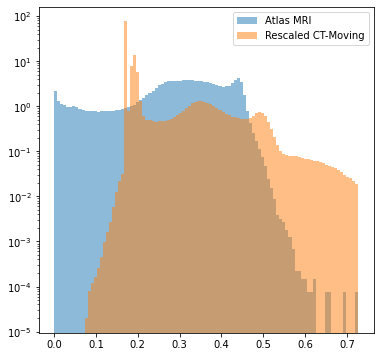

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize = (6, 6))

out_vals = ax1.hist(atlas_vol[atlas_vol>0], 100, label = 'Atlas MRI', alpha = 0.5, density=True, log = True)
ax1.hist(rescaled_moving_mr.ravel(), out_vals[1], label = 'Rescaled CT-Moving', alpha = 0.5, density=True, log = True)
ax1.legend()

### Model

In [ ]:
# our data will be of shape 160 x 192 x 224
vol_shape = atlas_vol_shape
nb_features = [
    [16, 32, 32, 32], # encoder
    [32, 32, 32, 32, 32, 16, 16] # decoder
]

In [ ]:
# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

### Validation data

Let's prepare our validation data.

In [ ]:
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

# val_input = [
#     val_volume_1[np.newaxis, ..., np.newaxis],
#     val_volume_2[np.newaxis, ..., np.newaxis]
# ]

val_input = [
    rescaled_moving_mr[np.newaxis, ..., np.newaxis],
    atlas_vol[np.newaxis, ..., np.newaxis]
]

In [ ]:
val_volume_1.shape, seg_volume_1.shape

((160, 192, 224), (160, 192, 224))

In [ ]:
val_input[0].shape, val_input[1].shape

((1, 160, 192, 224, 1), (1, 160, 192, 224, 1))

In [ ]:
# extract some brains
nb_vis = 5
x_train = rescaled_moving_mr[:,[2,0,1]]

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

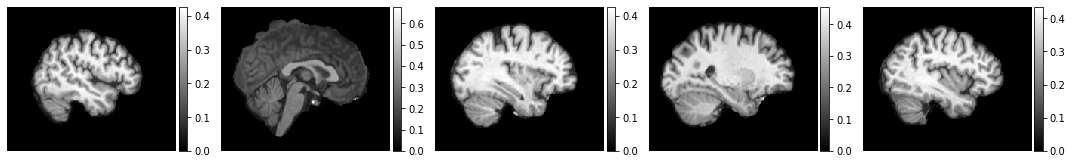

In [ ]:
# extract some brains
nb_vis = 5
x_train = val_volume_1

idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

Load a trained 3D model.

In [ ]:
vxm_model.load_weights('brain_3d.h5')

Now let's register.

In [ ]:
val_pred = vxm_model.predict(val_input);

In [ ]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

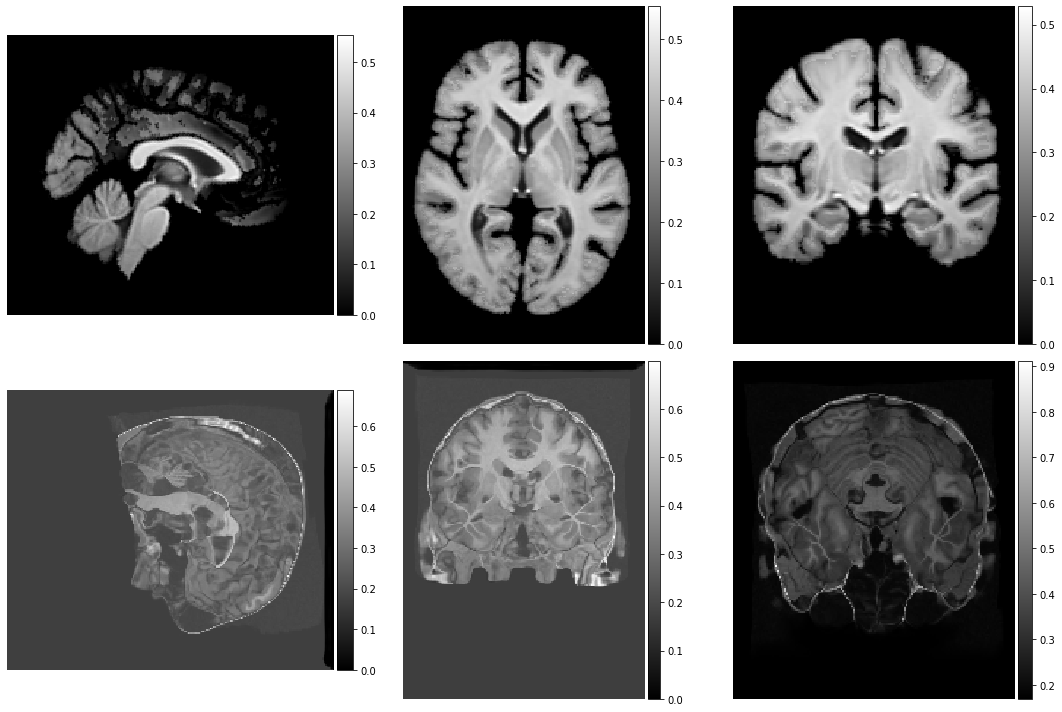

In [ ]:
mid_slices_fixed = [np.take(atlas_vol, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

In [ ]:
n_vol = zoom(n_vol, new_shape/old_shape)

In [ ]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2021-02-28 19:33:39--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16643404 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  15.3MB/s    in 1.0s    

2021-02-28 19:33:41 (15.3 MB/s) - ‘data.tar.gz’ saved [16643404/16643404]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
subj1.npz
subj2.npz
tutorial_data.npz


In [ ]:
vxm_atlas_vol.shape

(160, 192, 224)

In [ ]:
vxm_atlas_seg.shape

(160, 192, 224)

In [ ]:
val_volume_2 = np.load('atlas.npz')['vol']
seg_volume_2 = np.load('atlas.npz')['seg']

ValueError: ignored

In [ ]:
np.load('atlas.npz', allow_pickle=True,fix_imports=True,encoding='latin1')

OSError: ignored